# Moodsic — PERCEIVE E2E Flow Demo

Use this notebook to quickly experiment with the PERCEIVE stage.

Flow:
- Run Setup and Adapters.
- Run Helpers.
- In the Experiment cell, edit only `IMG_PATH`, then run it to see: preview, overlay with face box, and fused valence/arousal.

Notes:
- If adapters/weights are unavailable, the code degrades gracefully.
- Inputs must be 3-channel BGR images (OpenCV).


In [7]:
# Setup: ensure repo root on sys.path for imports from models/utils
import os, sys
from pathlib import Path
repo_root = Path.cwd()
# If notebook is opened from notebooks/, add parent as repo root
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import math
import numpy as np
try:
    import cv2
except Exception as e:
    raise RuntimeError(f'OpenCV (cv2) is required to run this demo: {e}')

from utils.runtime_driver import perceive_once
print('Repo root:', repo_root)


Repo root: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO


In [8]:
# Load adapters (best-effort) — tries both scene and face paths
scene_adapter = None
face_processor = None
face_adapter = None

# Scene adapter: CLIP ViT (requires transformers + pretrained weights)
try:
    from models.scene.clip_vit_scene_adapter import SceneCLIPAdapter
    scene_adapter = SceneCLIPAdapter(
        model_name='openai/clip-vit-base-patch32',
        dropout_rate=0.3,
        device='auto',
        tta=3,
    )
    print('SceneCLIPAdapter: OK')
except Exception as e:
    print(f'SceneCLIPAdapter unavailable (transformers/weights/device): {e}')

# Face processor: MediaPipe-based cropper (optional)
try:
    from utils.emonet_single_face_processor import EmoNetSingleFaceProcessor
    face_processor = EmoNetSingleFaceProcessor(min_detection_confidence=0.5, padding_ratio=0.2)
    print('Face processor available:', getattr(face_processor, 'available', False))
except Exception as e:
    print(f'Face processor unavailable (mediapipe missing?): {e}')

# Face adapter: EmoNet (optional weights from models/emonet/pretrained)
try:
    from models.face.emonet_adapter import EmoNetAdapter
    face_adapter = EmoNetAdapter(
        ckpt_dir='models/emonet/pretrained',
        n_classes=8,
        device='auto',
        tta=3,
        calibration_checkpoint=None,
    )
    print('EmoNetAdapter: OK')
except Exception as e:
    print(f'EmoNetAdapter unavailable (torch/weights/device): {e}')


I0000 00:00:1758640464.532894 16072131 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1758640464.536908 16097910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
No EmoNet checkpoint found in models/emonet/pretrained; using random initialization.


SceneCLIPAdapter: OK
Face processor available: True
EmoNetAdapter: OK


In [9]:
# Helpers: image loading and pretty printing of results
def load_image(path: str):
    # Accept absolute or relative; if missing, try to locate by basename anywhere in repo
    p = Path(path)
    if not p.exists():
        alt = repo_root / path
        if alt.exists():
            p = alt
        else:
            matches = list(repo_root.rglob(p.name)) if p.name else []
            if matches:
                p = matches[0]
                print(f'[info] image not found at given path; using first match: {p}')
            else:
                print(f'[skip] image not found: {path}')
                return None
    img = cv2.imread(str(p))
    if img is None:
        print(f'[skip] failed to read image: {p}')
        return None
    if img.ndim != 3 or img.shape[2] != 3:
        print('[skip] expecting a 3-channel BGR image')
        return None
    return img

def print_fusion_result(res, label: str = ''):
    if not res:
        print(f'{label} — no result')
        return
    def fmt_pred(p):
        if p is None:
            return 'None'
        return (
            f"V={p.valence:.3f}, A={p.arousal:.3f}, "
            f"varV={(p.var_valence if p.var_valence is not None else float('nan')):.4f}, "
            f"varA={(p.var_arousal if p.var_arousal is not None else float('nan')):.4f}, "
            f"valid={p.valid}"
        )
    scene_s = fmt_pred(res.scene)
    face_s = fmt_pred(res.face)
    fused_s = fmt_pred(res.fused)
    print(f'=== {label} ===')
    print(f'SCENE: {scene_s}')
    print(f'FACE : {face_s}')
    print(f'FUSED: {fused_s}')
    # Extras
    if getattr(res, 'face_bbox', None) is not None:
        print(f'face_bbox={res.face_bbox}, face_score={res.face_score:.3f}')
    if getattr(res, 'stability_variance', None) is not None:
        print(f'stability_variance={res.stability_variance}')
    if getattr(res, 'stability_jitter', None) is not None:
        print(f'stability_jitter={res.stability_jitter}')


## EXPERIMENTATION

Quick instructions to run single-image experiments:
- Run the three setup cells above: Setup, Adapters, Helpers.
- Pick an input path and set `IMG_PATH` in one of the Experiment cells below.
- Run that cell; it prints results and displays Preview and Overlay.

What you can change:
- `IMG_PATH`: absolute or repo-relative; the loader also searches by basename across the repo if not found at the given path.
- Fusion mode: edit the `perceive_once(...)` call to set `use_variance_weighting=True/False`.
- Fixed weights: when `use_variance_weighting=False`, add `scene_weight=0.6, face_weight=0.4` (tune as needed).
- TTA/uncertainty: adjust `scene_tta` and `face_tta` (lower values run faster, fewer samples).

Outputs and overlay:
- Console: SCENE, FACE, FUSED V/A with variances (`varV`, `varA`); lower variance = higher confidence.
- Overlay: draws face bbox (if detected) and writes fused/face/scene numbers on the image (right panel).

Dependencies and fallbacks:
- OpenCV (`cv2`) is required for IO and plotting.
- Scene adapter uses CLIP (transformers + pretrained weights). If unavailable, scene may be `None`.
- Face path needs MediaPipe for detection; EmoNet weights are optional (random init runs but is not meaningful).
- If a path is unavailable or invalid for a frame, fusion degrades to the other path.

Troubleshooting:
- If you see `[skip] image not found/failed to read`, fix `IMG_PATH` (absolute or repo-relative).
- If no face is detected, overlay shows no box and FACE may be unavailable; try another image.
- For dark/occluded frames, consider enabling face guardrails by passing `face_score_threshold`, `face_max_sigma`, or `brightness_threshold` into `perceive_once(...)`.


I0000 00:00:1758640464.839467 16072131 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1758640464.841146 16097957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


=== PERCEIVE — single image ===
SCENE: V=-0.077, A=-0.090, varV=0.3843, varA=0.0630, valid=True
FACE : V=0.026, A=0.044, varV=0.0000, varA=0.0000, valid=True
FUSED: V=0.026, A=0.042, varV=0.0010, varA=0.0010, valid=True
face_bbox=(388, 59, 371, 370), face_score=0.112


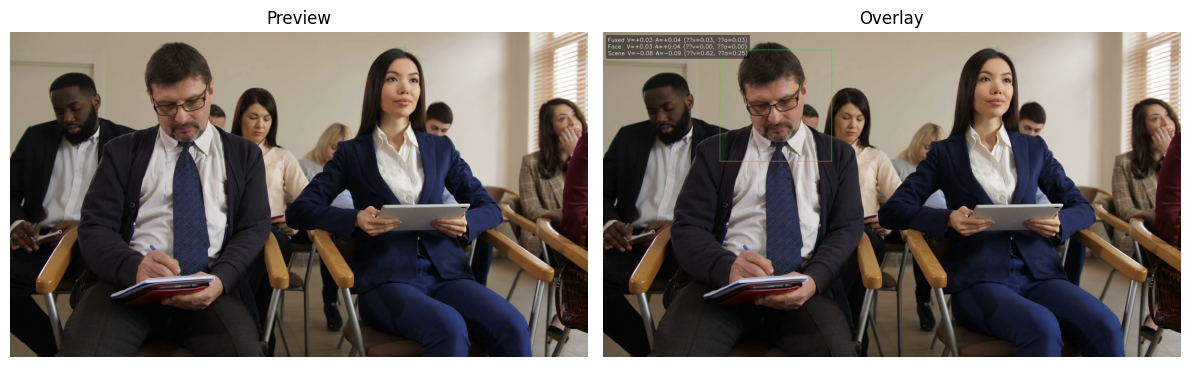

In [10]:
# Experiment: 
# Single image 
# 1. define the path
# 2. edit IMG_PATH and run this cell

# TODO: 1. define the path
WITH_FACE_IMG = (
    'data/Run_2/Accepting adults meeting/'
    'videoblocks-diverse-group-of-multinational-business-people-taking-part-in-'
    'corporate-meeting-bored-african-american-man-yawning-while-other-members-'
    'of-seminar-attentively-listening-speech-and-writing-notes_'
    'rsz1toto3e_thumbnail-1080_01.png'
)

# TODO: 2. update this with defined var above, then run the cell
IMG_PATH = WITH_FACE_IMG

img = load_image(IMG_PATH)
if img is None:
    raise SystemExit('Input image missing; update IMG_PATH and rerun.')

# Run PERCEIVE once using both adapters when available
res = perceive_once(
    img,
    scene_predictor=scene_adapter,
    face_processor=face_processor,
    face_expert=face_adapter,
    scene_tta=3,
    face_tta=3,
)
print_fusion_result(res, label='PERCEIVE — single image')

# Show preview and overlay
import matplotlib.pyplot as plt
try:
    from utils.fusion_overlay import draw_fusion_overlay
    over = draw_fusion_overlay(img, res)
except Exception as _e:
    over = None
    print(f'[info] overlay unavailable: {_e}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Preview')
plt.axis('off')

plt.subplot(1, 2, 2)
if over is not None:
    plt.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB))
    plt.title('Overlay')
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Overlay (unavailable; showing input)')
plt.axis('off')
plt.tight_layout()
plt.show()


=== PERCEIVE — single image ===
SCENE: V=-0.334, A=0.017, varV=0.0190, varA=0.1612, valid=True
FACE : V=0.000, A=0.000, varV=nan, varA=nan, valid=False
FUSED: V=-0.334, A=0.017, varV=0.0190, varA=0.1612, valid=True


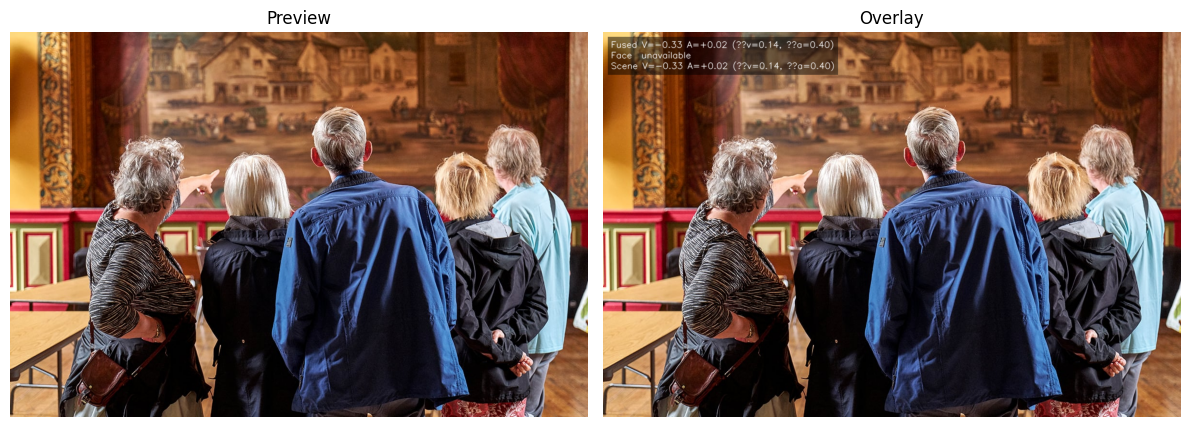

In [11]:
# Experiment: 
# Single image 
# 1. define the path
# 2. edit IMG_PATH and run this cell

# TODO: 1. define the path
NO_FACE_IMG = (
    'data/Run_2/Affectionate retiree competition/'
    'Elderly-group-in-museum-1200x800.jpg'
)

# TODO: 2. update this with defined var above, then run the cell
IMG_PATH = NO_FACE_IMG

img = load_image(IMG_PATH)
if img is None:
    raise SystemExit('Input image missing; update IMG_PATH and rerun.')

# Run PERCEIVE once using both adapters when available
res = perceive_once(
    img,
    scene_predictor=scene_adapter,
    face_processor=face_processor,
    face_expert=face_adapter,
    scene_tta=3,
    face_tta=3,
)
print_fusion_result(res, label='PERCEIVE — single image')

# Show preview and overlay
import matplotlib.pyplot as plt
try:
    from utils.fusion_overlay import draw_fusion_overlay
    over = draw_fusion_overlay(img, res)
except Exception as _e:
    over = None
    print(f'[info] overlay unavailable: {_e}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Preview')
plt.axis('off')

plt.subplot(1, 2, 2)
if over is not None:
    plt.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB))
    plt.title('Overlay')
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Overlay (unavailable; showing input)')
plt.axis('off')
plt.tight_layout()
plt.show()


=== PERCEIVE — single image ===
SCENE: V=0.055, A=0.023, varV=0.0419, varA=0.0258, valid=True
FACE : V=0.000, A=0.000, varV=nan, varA=nan, valid=False
FUSED: V=0.055, A=0.023, varV=0.0419, varA=0.0258, valid=True


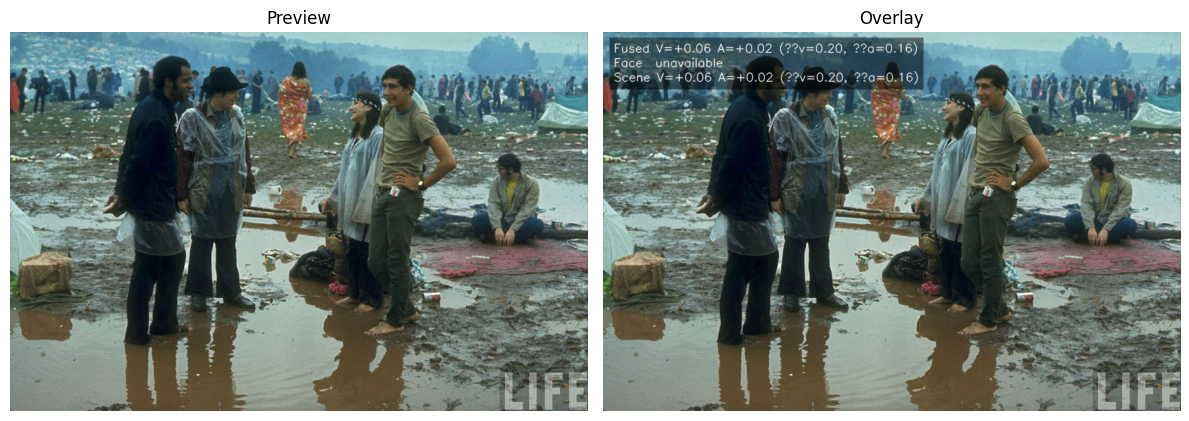

In [12]:
# Experiment: 
# Single image 
# 1. define the path
# 2. edit IMG_PATH and run this cell

# TODO: 1. define the path
WITH_FACE_FAR_IMG = (
    'data/Run_1/Affectionate people festival/'
    '1969-woodstock-music-festival-hippies-bill-eppridge-john-dominis-121-57bc3130c2d8b__880.jpg'
)

# TODO: 2. update this with defined var above, then run the cell
IMG_PATH = WITH_FACE_FAR_IMG 

img = load_image(IMG_PATH)
if img is None:
    raise SystemExit('Input image missing; update IMG_PATH and rerun.')

# Run PERCEIVE once using both adapters when available
res = perceive_once(
    img,
    scene_predictor=scene_adapter,
    face_processor=face_processor,
    face_expert=face_adapter,
    scene_tta=3,
    face_tta=3,
)
print_fusion_result(res, label='PERCEIVE — single image')

# Show preview and overlay
import matplotlib.pyplot as plt
try:
    from utils.fusion_overlay import draw_fusion_overlay
    over = draw_fusion_overlay(img, res)
except Exception as _e:
    over = None
    print(f'[info] overlay unavailable: {_e}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Preview')
plt.axis('off')

plt.subplot(1, 2, 2)
if over is not None:
    plt.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB))
    plt.title('Overlay')
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Overlay (unavailable; showing input)')
plt.axis('off')
plt.tight_layout()
plt.show()
